# Libraries

In [1]:
import scipy
import scipy.io
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import statistics
import math
import time
from tqdm import trange

# Load Data and Set Parameters

In [2]:
data_name = 'I4D_raw'
brain_data = scipy.io.loadmat('C:\\co\\NIA\\Regularization\\MB_References\\BLSA_1742_04_MCIAD_m41\\' + data_name + '.mat')
I_raw = brain_data[data_name]

slice_roi = 4

#NESMA Filter parameters
txy = 3
tz = 3  
thresh = 5

I_slice = brain_data[data_name][:,:,slice_roi,:]

# Prepare Functions

In [3]:
def NESMA_filtering(raw,txy,tz,thresh,verbose=False):
    #Inputs:
    # raw    : 4D (x,y,z,MS) raw/noisy volume. x,y and z/slice are the spatial coordinates, while MS is the multispectral dimension
    # txy    : Defines the size, (2*txy+1)-by-(2*txy+1) in voxels, of the search window in the x-y plane.
    # tz     : Defines the size, (2*tz+1) in voxels, of the search window in the z direction (a.k.a slice direction).
    # thresh : 100%-thresh defines the similarity threshold (%). Values between 1% to 10% are recommended.
    
    # Output:
    # S_NESMA: 4D (x,y,z,MS) NESMA-filtered volume
    
    (m,n,o,p) = raw.shape
    S_NESMA = np.zeros((m,n,o,p))
    
    for k in trange(o):
        if verbose==True:
            print('NESMA filtering ... Slice #', k, 'of', o)
        for i in range(m):
            for j in range(n):
                if raw[i,j,k,0]>10:
                    rmin=max(i-txy,0)
                    rmax=min(i+txy,m)
                    
                    smin=max(j-txy,0)
                    smax=min(j+txy,n)
                    
                    tmin=max(k-tz,0)
                    tmax=min(k+tz,o)
                    
                    L = (rmax-rmin)*(smax-smin)*(tmax-tmin)
                    
                    rawi = np.reshape(raw[rmin:rmax,smin:smax,tmin:tmax,:],(L,p))
                    x=raw[i,j,k,:]
                    
                    D = 100*np.sum(abs(rawi-x),axis=1)/np.sum(x)
                    pos = D<thresh
                    
                    S_NESMA[i,j,k,:] = np.mean(rawi[pos==True, :], axis=0)
                    
    return S_NESMA

def NESMA_filtering_3D(raw,txy,thresh,verbose=False):
    #Inputs:
    # raw    : 3D (x,y,MS) raw/noisy volume. x,y are the spatial coordinates, while MS is the multispectral dimension
    # txy    : Defines the size, (2*txy+1)-by-(2*txy+1) in voxels, of the search window in the x-y plane.
    # thresh : 100%-thresh defines the similarity threshold (%). Values between 1% to 10% are recommended.

    # Output:
    # S_NESMA: 3D (x,y,MS) NESMA-filtered volume
    
    (m,n,o) = raw.shape
    S_NESMA = np.zeros((m,n,o))
    
    for j in trange(n):
        if verbose==True and j%50==0:
            print('NESMA filtering ... Slice #', j, 'of', n)
        for i in range(m):
            rmin=max(i-txy,0)
            rmax=min(i+txy,m)
                    
            smin=max(j-txy,0)
            smax=min(j+txy,n)
                    
            L = (rmax-rmin)*(smax-smin)
        
            rawi = np.reshape(raw[rmin:rmax,smin:smax,:],(L,o)) #GSH - Different than the 4D version but seems appropriate
            x=raw[i,j,:]
            
            if x[0] != 0:
                D = 100*np.sum(abs(rawi-x),axis=1)/np.sum(x) #This is the Relative Manhattan distance between voxel intensities
                pos = D<thresh
                    
                S_NESMA[i,j,:] = np.mean(rawi[pos==True,:], axis=0)
    
    return S_NESMA

# Process Data

In [4]:
I_filtered = NESMA_filtering_3D(I_slice, txy, thresh, verbose = False)

I_filtered_4D = NESMA_filtering(I_raw, txy, tz, thresh, verbose = False)

print(f"Pixels with differences after 3D filtering = {np.sum(np.sum(np.abs(I_filtered-I_slice),axis = 2)>0)} out of {I_slice.shape[0]*I_slice.shape[1]}")

print(f"Pixels with differences after 4D filtering = {np.sum(np.sum(np.abs((I_filtered_4D-I_raw))[:,:,slice_roi,:],axis = 2)>0)} out of {I_slice.shape[0]*I_slice.shape[1]}")

100%|██████████| 10/10 [01:51<00:00, 11.15s/it]


Pixels with differences after 3D filtering = 6973 out of 82944
Pixels with differences after 4D filtering = 23731 out of 82944


# Figures for NESMA product

In [10]:
#Normalize the NESMA filtered data and account for Rician noise
I_norm_NESMA = np.zeros(I_slice.shape)
for i_hori in trange(I_slice.shape[0]):
    for i_vert in range(I_slice.shape[1]):
        #for i_slice in range(n_slices):
        data = I_filtered[i_hori,i_vert,:]
            #Account for the Rician noise
        signal_end = data[(I_slice.shape[-1]-10):]
        rician_correction = np.mean(signal_end)
        data_shifted = data-rician_correction
            #Normalize the data
        data_shifted = np.array(data_shifted/data_shifted[0])

        I_norm_NESMA[i_hori,i_vert,:] = data_shifted

  0%|          | 0/288 [00:00<?, ?it/s]C:\Users\griff\AppData\Local\Temp\ipykernel_4704\3990698638.py:12: RuntimeWarning: invalid value encountered in divide
  data_shifted = np.array(data_shifted/data_shifted[0])
 14%|█▎        | 39/288 [00:00<00:02, 88.68it/s]C:\Users\griff\AppData\Local\Temp\ipykernel_4704\3990698638.py:12: RuntimeWarning: divide by zero encountered in divide
  data_shifted = np.array(data_shifted/data_shifted[0])
100%|██████████| 288/288 [00:02<00:00, 101.25it/s]


  0%|          | 0/288 [00:00<?, ?it/s]C:\Users\griff\AppData\Local\Temp\ipykernel_4704\4161238884.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  brain_SNR_temp = data[0]/brain_noise_sd
100%|██████████| 288/288 [00:02<00:00, 142.69it/s]


ValueError: supplied range of [0.23408229439226114, inf] is not finite

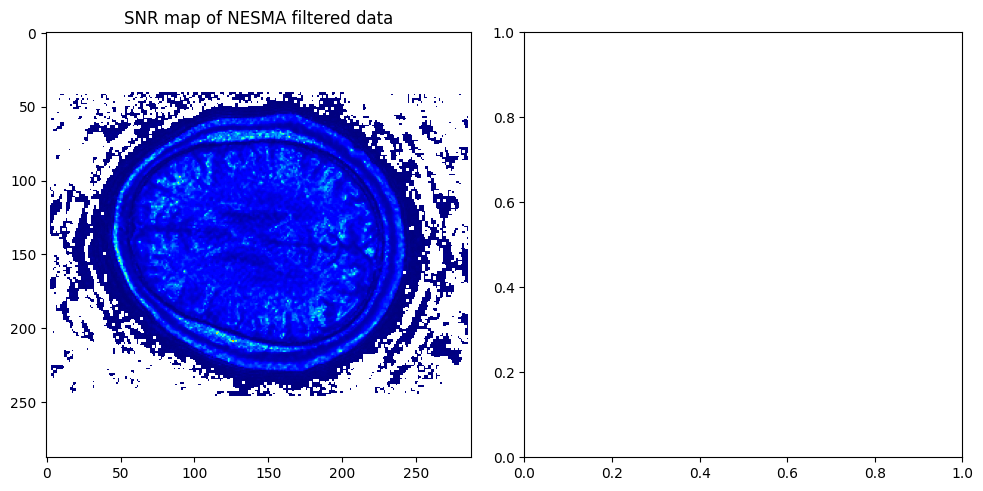

In [11]:
brain_SNR_map_NESMA = np.zeros((I_slice.shape[0], I_slice.shape[1]))
for i_hori in trange(I_slice.shape[0]):
    for i_vert in range(I_slice.shape[1]):
        data = I_filtered[i_hori,i_vert,:]
        if data[0]>0:
            signal_end = data[(I_slice.shape[-1]-10):] #Accounting for noise in the data - Rician noise
            
            brain_noise_sd = np.std(signal_end)
            brain_SNR_temp = data[0]/brain_noise_sd
            brain_SNR_map_NESMA[i_hori, i_vert] = brain_SNR_temp
        else:
            brain_SNR_map_NESMA[i_hori, i_vert] = None
            
fig, ax = plt.subplots(1, 2, figsize=(10,5),tight_layout=True)
imc1 = ax[0].imshow(brain_SNR_map_NESMA, cmap = 'jet')
ax[0].set_title('SNR map of NESMA filtered data')

n, bins, patches = ax[1].hist(np.reshape(brain_SNR_map_NESMA[brain_SNR_map_NESMA>0],-1), bins=20)
bincenters_NESMA = 0.5*(bins[1:]+bins[:-1])
#print(bincenters_NESMA)
print('SNR mean:',np.mean(brain_SNR_map_NESMA[brain_SNR_map_NESMA>0]))
ax[1].set_title('Histogram of SNR of NESMA filtered data')

fig.colorbar(imc1,ax=ax[0],fraction=0.046, pad=0.04)

plt.show()